1) реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации

2) реализовать ограничение глубины дерева при построении. Построить на этом же датасете дерево, у которого максимальная глубна листа равна 2.

3)* реализовать на листьях дерева рассчёт доли/вероятности принадлежности к классу. Рассчитать вероятности предстказываемые для объектов тестовой выборки, вычислить с их помощью AUC-ROC и AUC-PR характеристики

____

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
from collections import Counter

____

In [4]:
class DessionTreeClassifier:

    def __init__(self, min_leaf=5, max_depth=np.inf, inf_value_type="Gini"):
        self.min_leaf = min_leaf
        self.inf_value_type = inf_value_type
        self.max_depth = max_depth
        self.node_dict = {}
        self.leaf_list = []
        self.level = 0
        self.prediction_mask = {}
        self.prediction = None
        self.y_proba = None
        self.proba_data = None

    @staticmethod
    def get_label_num(y_list):
        num = Counter(y_list)
        return dict(num)

    def get_informative_value(self, y_list):
        labels_dict = self.get_label_num(y_list)

        if self.inf_value_type == "Gini":
            impurity = 1
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                impurity -= p_label**2
            return impurity

        if self.inf_value_type == "Shannon":
            entropy = 0
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                entropy -= p_label * (0 if (p_label == 0)
                                      else np.log2(p_label))
            return entropy

    def find_best_split(self, X, y):

        current_informative_value = self.get_informative_value(y)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]

        for index in range(n_features):
            t_values = set(X[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.data_split(
                    X, y, index, t)
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.merit_functional(
                    true_labels, false_labels, current_informative_value)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def merit_functional(self, true_labels, false_labels, current_informative_value):

        p = (true_labels.shape[0]) / ((true_labels.shape[0]) + (false_labels.shape[0]))
        quality = current_informative_value - p * \
            self.get_informative_value(true_labels) - (1 - p) * \
            self.get_informative_value(false_labels)
        return quality

    def data_split(self, X, y, feature_idx, t):

        left = (X[:, feature_idx] <= t)

        true_data = X[left]
        false_data = X[~left]
        true_labels = y[left]
        false_labels = y[~left]
        return true_data, false_data, true_labels, false_labels

    def fit(self, X, y):

        data_id = 0
        data_list = []
        data_list.append([X, y, None, None, data_id])
        tree_params = []
        next_level_data = []
        fl = 0
        mask = []

        while not fl:
            if self.level > 0:
                data_list.clear()
                data_list = next_level_data.copy()
                next_level_data.clear()

            for data in data_list:

                best_quality, best_t, best_index = self.find_best_split(
                    data[0], data[1])
                if best_quality and (self.level <= self.max_depth):
                    true_data, false_data, true_labels, false_labels = self.data_split(
                        data[0], data[1], best_index, best_t)
                    self.node_dict[data[4]] = [
                        data[2], data[3], best_index, best_t]
                    data_id += 1
                    next_level_data.append(
                        [true_data, true_labels, True, data[4], data_id])
                    data_id += 1
                    next_level_data.append(
                        [false_data, false_labels, False, data[4], data_id])
                else:
                    leaf = self.get_label_num(data[1])
                    prediction = max(leaf, key=leaf.get)
                    proba = leaf[prediction] / len(data[0])
                    if prediction == 0:
                        proba = 1 - proba
                    self.leaf_list.append(
                        [data[2], data[3], proba, prediction])

                self.level += 1

            if (next_level_data == []):
                fl = 1

        for leaf in self.leaf_list:
            mask = [(leaf[0], leaf[1])]
            next_step = leaf[1]

            while True:

                if next_step is not None and next_step != 0:
                    mask.append(
                        (self.node_dict[next_step][0], self.node_dict[next_step][1]))
                    next_step = self.node_dict[next_step][1]
                else:
                    mask.reverse()
                    self.prediction_mask[tuple(mask)] = leaf[2], leaf[3]
                    break

    def predict(self, X):

        y_pred_proba_list = [None for i in range(len(X))]

        for mask in self.prediction_mask:
            answer_mask = []
            predict_mask = [mask[i][0] for i in range(len(mask))]

            for question in mask:
                idx = self.node_dict[question[1]][2]
                t = self.node_dict[question[1]][3]
                y_pred_proba = [self.prediction_mask[mask]]
                answer_mask.append(X[:, idx] <= t)
                answer_mask_array = np.array(answer_mask).T.tolist()

            for num, answer in enumerate(answer_mask_array):
                if answer == predict_mask and y_pred_proba_list[num] is None:
                    y_pred_proba_list[num] = y_pred_proba

        self.prediction = np.array(y_pred_proba_list).reshape(-1, 2)[:, 1]
        self.y_proba = np.array(y_pred_proba_list).reshape(-1, 2)[:, 0]

        return self.prediction, self.y_proba

    def metrics(self, y_true, y_pred, metric='f1_score', f1_beta=1):

        TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
        FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
        TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))

        if metric == 'accuracy':
            accuracy = (TP + TN) / y_true.shape[0]
            return accuracy

        if metric == 'pre_rec':
            precision = TP/(TP + FP)
            recall = TP/(TP + FN)
            return round(precision, 3), round(recall, 3)

        if metric == 'f1_score':
            f1_score = (1 + f1_beta**2)*(precision * recall) / \
                (f1_beta * precision + recall)
            return f1_score

        if metric == 'matrix':
            return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
        if metric == 'accuracy_balanced':
            accuracy_balanced = 0.5 * (TP / (TP + FN) + TN / (TN + FP))
            return accuracy_balanced

    def get_proba_data(self, y_true):

        self.proba_data = pd.DataFrame(
            {'proba': self.y_proba, 'y_true': y_true})
        self.proba_data = self.proba_data.sort_values(
            by='proba', ascending=False).reset_index(drop=True)

    def roc_auc(self, y_true):

        if self.proba_data is None:
            self.get_proba_data(y_true)
        N = len(y_true)
        n_pos = np.count_nonzero(y_true)
        n_neg = N - n_pos
        TP = 0
        FP = 0
        TPR = [0]
        FPR = [0]
        for i in range(N):
            if self.proba_data.iloc[i, 1] == 1:
                TP += 1
            else:
                FP += 1
            TPR.append(TP/n_pos)
            FPR.append(FP/n_neg)
        ROC_AUC = np.trapz(TPR, x=FPR, dx=0.1)

        plt.figure(figsize=(12, 8))
        plt.plot(FPR, TPR, color='b', linewidth=2,
                 label=f'ROC curve\nROC_AUC = {round (ROC_AUC, 3)}')
        plt.plot((0, 1), (0, 1), color='dimgray',
                 linewidth=1, linestyle='dashed')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.fill_between(FPR, TPR, alpha=0.5, color='lightblue')
        if N <= 100:
            plt.scatter(FPR, TPR, edgecolors='white', s=55, c='dimgray')
        plt.legend(loc='best', facecolor='white', shadow=True, fontsize=15)
        plt.show()

    def pr_auc(self, y_true):

        if self.proba_data is None:
            self.get_proba_data(y_true)
        N = len(y_true)
        n_pos = np.count_nonzero(y_true)
        n_neg = N - n_pos
        TP = 0
        FP = 0
        recall = [0]
        precision = [0]

        for i in range(N):
            if self.proba_data.iloc[i, 1] == 1:
                TP += 1
            else:
                FP += 1
            recall.append(TP/n_pos)
            precision.append(TP/(TP + FP))
        PR_AUC = np.trapz(precision, x=recall, dx=0.1)

        plt.figure(figsize=(12, 8))
        plt.plot(recall, precision, color='b', linewidth=2,
                 label=f'PR curve\nPR_AUC = {round(PR_AUC, 3)}')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.fill_between(recall, precision, alpha=0.5, color='lightblue')
        if N <= 100:
            plt.scatter(recall, precision, edgecolors='white', s=55, c='dimgray')
        plt.legend(loc='best', facecolor='white', shadow=True, fontsize=15)
        plt.show()

*******

In [5]:
from sklearn import datasets
from sklearn import model_selection
X, y = datasets.make_classification(n_features=2, n_informative=2, n_samples=100,
                                    n_classes=2, n_redundant=0,
                                    n_clusters_per_class=1, random_state=5)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=1)

In [6]:
# проверка работы на критерии информативности "Gini"

dt_classification_gini = DessionTreeClassifier(inf_value_type="Gini")
dt_classification_gini.fit(X_train, y_train)
y_pred_train, y_proba = dt_classification_gini.predict(X_train)
y_pred_test, _ = dt_classification_gini.predict(X_test)

print(
    f'Метрика accuracy для test: '
    f'{dt_classification_gini.metrics(y_test, y_pred_test, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy для train: '
    f'{dt_classification_gini.metrics(y_train, y_pred_train, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy balanced для test: '
    f'{dt_classification_gini.metrics(y_test, y_pred_test, metric="accuracy_balanced"):.3f}')
print(
    f'Метрика accuracy balanced для train: '
    f'{dt_classification_gini.metrics(y_train, y_pred_train, metric="accuracy_balanced"):.3f}')

Метрика accuracy для test: 1.000
Метрика accuracy для train: 0.986
Метрика accuracy balanced для test: 1.000
Метрика accuracy balanced для train: 0.986


In [7]:
# проверка работы на критерии информативности "Shennon"

dt_classification_shan = DessionTreeClassifier(inf_value_type="Shannon")
dt_classification_shan.fit(X_train, y_train)
y_pred_train, y_proba = dt_classification_shan.predict(X_train)
y_pred_test, _ = dt_classification_shan.predict(X_test)

print(
    f'Метрика accuracy для test: '
    f'{dt_classification_shan.metrics(y_test, y_pred_test, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy для train: '
    f'{dt_classification_shan.metrics(y_train, y_pred_train, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy balanced для test: '
    f'{dt_classification_shan.metrics(y_test, y_pred_test, metric="accuracy_balanced"):.3f}')
print(
    f'Метрика accuracy balanced для train: '
    f'{dt_classification_shan.metrics(y_train, y_pred_train, metric="accuracy_balanced"):.3f}')

Метрика accuracy для test: 1.000
Метрика accuracy для train: 0.986
Метрика accuracy balanced для test: 1.000
Метрика accuracy balanced для train: 0.986


In [8]:
# проверка работы на критерии информативности "Gini" при глубине дерева 2

dt_classification_gini_2 = DessionTreeClassifier(inf_value_type="Gini", max_depth=2)
dt_classification_gini_2.fit(X_train, y_train)
y_pred_train, y_proba = dt_classification_gini_2.predict(X_train)
y_pred_test, _ = dt_classification_gini_2.predict(X_test)

print(
    f'Метрика accuracy для test: '
    f'{dt_classification_gini_2.metrics(y_test, y_pred_test, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy для train: '
    f'{dt_classification_gini_2.metrics(y_train, y_pred_train, metric="accuracy"):.3f}')
print(
    f'Метрика accuracy balanced для test: '
    f'{dt_classification_gini_2.metrics(y_test, y_pred_test, metric="accuracy_balanced"):.3f}')
print(
    f'Метрика accuracy balanced для train: '
    f'{dt_classification_gini_2.metrics(y_train, y_pred_train, metric="accuracy_balanced"):.3f}')

Метрика accuracy для test: 0.967
Метрика accuracy для train: 0.929
Метрика accuracy balanced для test: 0.967
Метрика accuracy balanced для train: 0.929


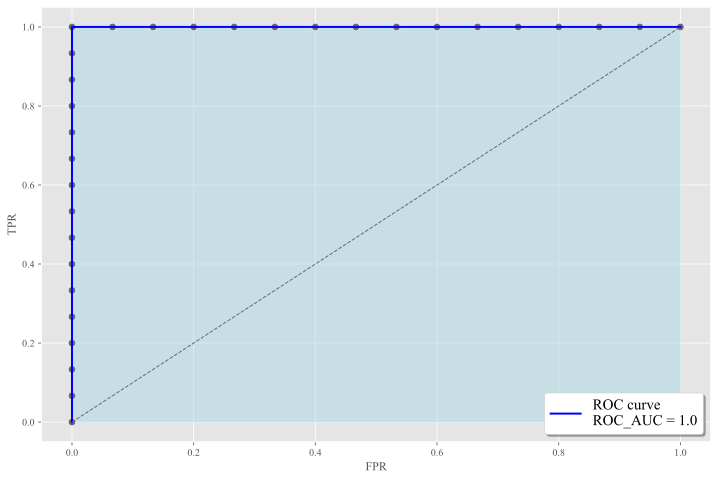

In [9]:
# построим ROC_AUC PR_AUC
dt_classification_gini.roc_auc(y_test)

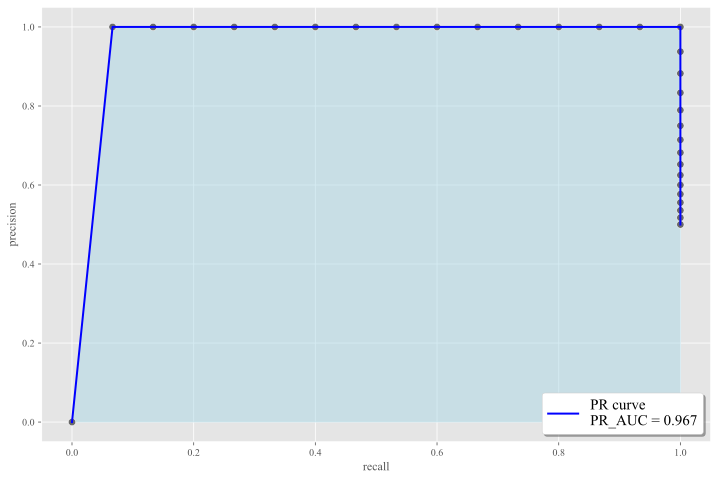

In [10]:
dt_classification_gini.pr_auc(y_test)